In [1]:
%reload_ext sql
%config SqlMagic.autocommit=False
%config SqlMagic.autolimit=0
%config SqlMagic.autopandas=True
%config SqlMagic.displaylimit=200
%sql trino://localhost:9090/cuebiq/

'Connected: @cuebiq/'

In [2]:
schema = 'ds_data_for_complexity'
q = f"""show tables from dedicated.{schema}"""
%sql $q

stops_table_name = f'dedicated.{schema}.selected_stops'
device_location_table_name = f'dedicated.{schema}.device_location_and_stops_subsampled_v2'

query = f"""
with stops as(
    SELECT *
    FROM {stops_table_name}
),

events_ AS (
    SELECT *,
           LAG(stop_start_unix_timestamp) OVER (PARTITION BY lineage_id, data_provider, id_type ORDER BY zoned_datetime) AS prev_stop_start_unix_timestamp,
           LAG(stop_end_unix_timestamp) OVER (PARTITION BY lineage_id, data_provider, id_type ORDER BY zoned_datetime) AS prev_stop_end_unix_timestamp,
           LAG(zoned_datetime) OVER (PARTITION BY lineage_id, data_provider, id_type ORDER BY stop_start_unix_timestamp) AS prev_zoned_datetime,
           LAG(dwell_time_minutes) OVER (PARTITION BY lineage_id, data_provider, id_type ORDER BY stop_start_unix_timestamp) AS prev_dwell_time_minutes,
           LEAD(stop_start_unix_timestamp) OVER (PARTITION BY lineage_id, data_provider, id_type ORDER BY zoned_datetime) AS next_stop_start_unix_timestamp
    FROM stops
),

good_stops AS(
SELECT 
    lineage_id,  
    geohash,
    lat, lng,
    id_type,
    zoned_datetime, 
    COALESCE(stop_start_unix_timestamp, 0) as stop_start_unix_timestamp,
    COALESCE(stop_end_unix_timestamp, 0) as stop_end_unix_timestamp,
    COALESCE(prev_stop_start_unix_timestamp, 0) as prev_stop_start_unix_timestamp,
    COALESCE(prev_stop_end_unix_timestamp, 0) as prev_stop_end_unix_timestamp,
    CASE
        WHEN stop_start_unix_timestamp < prev_stop_end_unix_timestamp THEN 1 
        ELSE 0
    END as overlapping_stop,
    CAST(date_format(from_iso8601_timestamp(zoned_datetime), '%Y%m%d') AS INTEGER) AS event_date,
    data_provider
FROM events_
)

SELECT DISTINCT *
FROM good_stops
"""
df_stops = %sql $query

 * trino://localhost:9090/cuebiq/
Done.
 * trino://localhost:9090/cuebiq/
Done.


In [3]:
!pip install seaborn -q -q
!pip install geohash2 -q -q

import pandas as pd
from datetime import datetime
import numpy as np
import seaborn as sns
from scipy import stats
from keplergl import KeplerGl

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import ScalarFormatter

import geohash2
import json

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

In [4]:
query = f"""
select *
from {device_location_table_name}
where event_date = 20240406
"""
df_dev_loc = %sql $query

 * trino://localhost:9090/cuebiq/
Done.


In [10]:
df_dev_loc[(df_dev_loc.stop_id.isna())]\
         .sort_values(['lineage_id', 'event_timestamp']).head()

,data_provider,id_type,lineage_id,event_timestamp,event_zoned_datetime,lat,lng,geohash,accuracy,classification_type,stop_zoned_datetime,stop_dwell_time_minutes,stop_start_unix_timestamp,stop_end_unix_timestamp,stop_geohash,stop_id,stop_class,subsampled,admin1,admin2,event_date
1627388,SDK,IDFA,9223372027778195354,1712402998,2024-04-06T07:29:58-04:00,40.864166,-74.470256,dr703rh7j,59.856355,WHITELISTED,None,0.0,0,0,None,None,NaN,NaN,US.NJ,US.NJ.027,20240406
1637242,SDK,IDFA,9223372027778195354,1712403001,2024-04-06T07:30:01-04:00,40.864863,-74.470810,dr703rhp0,7.802397,WHITELISTED,None,0.0,0,0,None,None,NaN,NaN,US.NJ,US.NJ.027,20240406
1517882,SDK,IDFA,9223372027778195354,1712403007,2024-04-06T07:30:07-04:00,40.865509,-74.471677,dr703r76u,3.586112,OTHER,None,0.0,0,0,None,None,NaN,NaN,US.NJ,US.NJ.027,20240406
1510745,SDK,IDFA,9223372027778195354,1712403009,2024-04-06T07:30:09-04:00,40.865723,-74.471975,dr703r7hj,3.535534,OTHER,None,0.0,0,0,None,None,NaN,NaN,US.NJ,US.NJ.027,20240406
1234692,SDK,IDFA,9223372027778195354,1712403013,2024-04-06T07:30:13-04:00,40.866119,-74.472565,dr703r6wr,4.591672,WHITELISTED,None,0.0,0,0,None,None,NaN,NaN,US.NJ,US.NJ.027,20240406


In [25]:
query = f"""
WITH time_table AS (
    SELECT
        lineage_id,
        event_timestamp,
        id_type,
        LEAD(event_timestamp) OVER (PARTITION BY lineage_id, data_provider, id_type ORDER BY event_zoned_datetime) AS next_timestamp
    FROM {device_location_table_name}
    WHERE event_date = 20240406
    and lineage_id % 10=0
)

SELECT
    lineage_id,
    id_type,
    (next_timestamp - event_timestamp) AS difference_in_seconds
FROM time_table
"""

df_delta_t_per_ID = %sql $query

 * trino://localhost:9090/cuebiq/
Done.


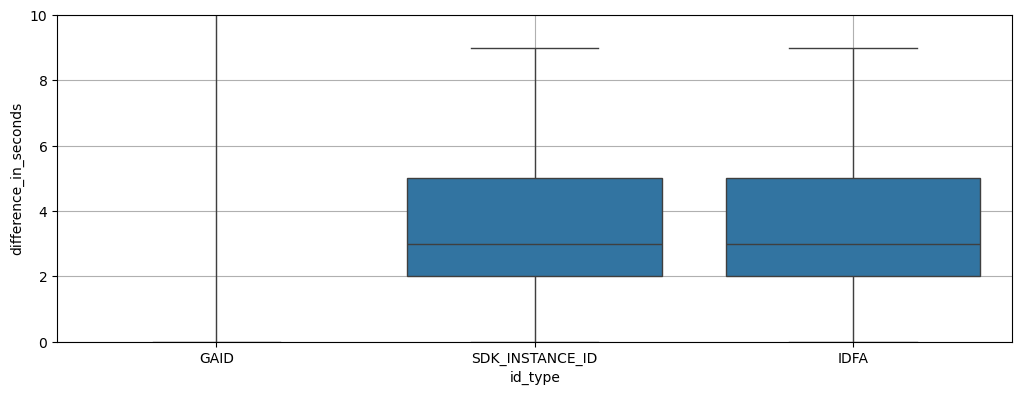

In [26]:
plt.figure(figsize=(10.5, 4))

sns.boxplot(df_delta_t_per_ID, x='id_type', y='difference_in_seconds', showfliers=False)

plt.grid(True)
plt.tight_layout()
plt.ylim(0,10)
plt.show()

df_delta_t_per_ID[id_type=='IDFA']


In [32]:
mean_difference_per_id_type = df_delta_t_per_ID.groupby('id_type')['difference_in_seconds'].median()

# Display the result
print(mean_difference_per_id_type)

id_type
GAID               3540.0
IDFA                  3.0
SDK_INSTANCE_ID       3.0
Name: difference_in_seconds, dtype: float64


In [52]:
query = f"""
SELECT lineage_id, geohash_6, stop_start_unix_timestamp
FROM {stops_table_name}
WHERE lineage_id = 9223372028664353817
"""

df_stops = %sql $query



 * trino://localhost:9090/cuebiq/
Done.


In [70]:
df_stops
# Convert UNIX timestamp to datetime
df_stops['datetime'] = pd.to_datetime(df_stops['stop_start_unix_timestamp'], unit='s')

# Convert UNIX timestamp to datetime
df_stops['datetime'] = pd.to_datetime(df_stops['stop_start_unix_timestamp'], unit='s')

# Get the day of the week
df_stops['day_of_week'] = df_stops['datetime'].dt.day_name()

# Count the occurrences of each day of the week for each geohash
day_geohash_counts = df_stops.groupby(['day_of_week', 'geohash_6']).size().reset_index(name='count')

day_geohash_counts


,day_of_week,geohash_6,count
0,Friday,dr5zdp,1
1,Friday,dr7b12,1
2,Friday,dr7bh5,1
3,Friday,dr7bh7,1
4,Friday,dr7bnm,1
5,Friday,dr7bpj,3
6,Friday,drhpb7,1
7,Friday,drhpbm,2
8,Friday,drhpbz,2
9,Friday,drhpfk,2
